# Training

In [1]:
import math
import joblib
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import math
import joblib
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import norm, gaussian_kde

pd.set_option('display.float_format', '{:.2f}'.format)

## Import dataset

In [2]:
data_path = Path().cwd() / "data" / "df_train.csv"
df = pd.read_csv(data_path)

## Data cleansing

In [3]:
def clean_data(df):
    df['edad'] = df['edad'].where(df['edad'] <= 100, np.nan)
    df["saldo_productos_activos"] = df["saldo_productos_activos"].where(df["saldo_productos_activos"] >= 1000.00, np.nan)
    df["saldo_productos_pasivos"] = df["saldo_productos_pasivos"].where(df["saldo_productos_pasivos"] <= 47995816.00, np.nan)
    df["cantidad_productos_activos"] = df["cantidad_productos_activos"].where(df["cantidad_productos_activos"] <= 15, np.nan)
    df["cantidad_productos_pasivos"] = df["cantidad_productos_pasivos"].where(df["cantidad_productos_pasivos"] <= 15, np.nan)
    return df

df_cleansed = clean_data(df)

## Data partitioning

In [4]:
X = df_cleansed.drop(['tasa_interes', "id"], axis=1) 
y = df_cleansed.tasa_interes 

X_train, X_test, y_train, y_test = train_test_split(df_cleansed, y, test_size=0.3, random_state=42)
y_train = y_train.values.ravel() 

## Feature engineering

In [5]:
# Step 1: Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Step 2: Create transformers for each type
numerical_transformer = KNNImputer(n_neighbors=5)

# Step 3: Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(n_neighbors=5), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Step 4: Fit and transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Model training

In [6]:
# 1. Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 2. Define hyperparameter search space for Random Forest
param_distributions = {
    'regressor__n_estimators': randint(50, 300),
    'regressor__max_depth': randint(5, 50),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2']
}

# 3. Set up randomized search cross-validation
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50, 
    cv=10, 
    scoring='r2',
    random_state=42,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

# 4. Run the search
random_search.fit(X_train, y_train)

# 5. Best model and parameters
print("Best hyperparameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END regressor__max_depth=43, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   1.9s
[CV] END regressor__max_depth=43, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   1.9s
[CV] END regressor__max_depth=43, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   1.9s
[CV] END regressor__max_depth=43, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   1.8s
[CV] END regressor__max_depth=43, regressor__max_features=log2, regressor__min_samples_leaf=8, regressor__min_samples_split=6, regressor__n_estimators=70; total time=   1.9s
[CV] END regressor__max_depth=43, regressor__max_features=log2, reg

/Users/pititot/Documents/CienciaDatos/interest-rate-optimization/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END regressor__max_depth=13, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=138; total time=   2.0s
[CV] END regressor__max_depth=18, regressor__max_features=log2, regressor__min_samples_leaf=9, regressor__min_samples_split=3, regressor__n_estimators=102; total time=   1.5s
[CV] END regressor__max_depth=13, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=138; total time=   2.0s
[CV] END regressor__max_depth=13, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=138; total time=   2.2s
[CV] END regressor__max_depth=13, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=138; total time=   2.2s
[CV] END regressor__max_depth=13, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=5

## Model evaluation

In [7]:
y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
y_pred

MAE: 1.1180331834454562
MSE: 2.8196005597636105
R2: 0.8532547643200956
RMSE:  1.6791666265631922


array([17.59442299, 15.94453717,  6.66718592, ..., 11.22934672,
       18.37876744, 12.07289963], shape=(3825,))

## Model export

- Exportar modelo como un .joblib

In [9]:
joblib.dump(random_search.best_estimator_, 'model/random_forest_pipeline_model.joblib')
loaded_model = joblib.load('model/random_forest_pipeline_model.joblib')
predictions = loaded_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))


MAE: 1.1180331834454562
MSE: 2.8196005597636105
R2: 0.8532547643200956
RMSE:  1.6791666265631922


MAE: 1.1168931372549022
MSE: 2.8113303315849683
R2: 0.853685185777844
RMSE:  1.6767022191149412

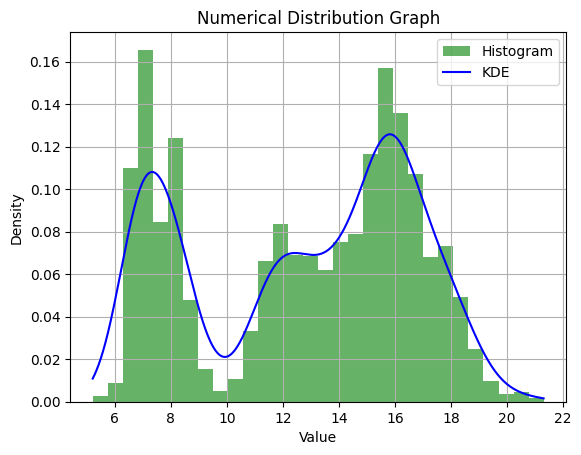

In [ ]:
import os
os.listdir()

def numerical_distribution_graph(data_array):
    # Plot histogram
    plt.hist(data_array, bins=30, density=True, alpha=0.6, color='g', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(data_array, bw_method='scott')
    x_vals = np.linspace(min(data_array), max(data_array), 1000)
    kde_vals = kde(x_vals)

    # Plot KDE line
    plt.plot(x_vals, kde_vals, label='KDE', color='blue')

    plt.title('Numerical Distribution Graph')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

numerical_distribution_graph(predictions)